In [1734]:
# CMPS140 Project - How to Become Top Earner in Airbnb?
# Tangni Wang, Tung Hoi Man, Yunxiang Fu
# {twang63, tuman, yfu7}@ucsc.edu

In [1735]:
# Tried:
# dropna for new_score_reviews

# To do:
# Generate graph
# Try StandardScaler


In [1736]:
import warnings
warnings.simplefilter("ignore")

import sklearn # sci-kit learn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error, explained_variance_score
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [1737]:
# Helper functions
def correction(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)    
    return (x)

def correction2(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('%','')
        x=float(x)/100.0
    return (x)

def to_int(x):
    '''
    Columns value corrections
    '''
    if x=='f':
        x=x.replace('f','0')
    elif x=='t':
        x=x.replace('t','1')
    else:
        x= '0'
    return int(x)

# def changeTime(x):
#     '''
#     change host_response_time columns from string into numerical.
#     '''
#     if x == 'within an hour':
#         x=x.replace('within an hour', '1')
#     elif x == 'within a few hours':
#         x=x.replace('within a few hours', '4')
#     elif x == 'within a day':
#         x=x.replace('within a day', '24')
#     elif x == 'a few days or more':
#         x=x.replace('a few days or more', '48')
#     else:
#         x='96'
        
#     return int(x)

def changeTime(x):
    '''
    change host_response_time columns from string into numerical.
    '''
    if x == 'within an hour':
        x='1'
    elif x == 'within a few hours':
        x='4'
    elif x == 'within a day':
        x='24'
    elif x == 'a few days or more':
        x='48'
    else:
        x='96'
        
    return x

def convertPolicy(x):
    '''
    Convert cancellation_policy columns from string into numerical.
    '''
    if x == 'strict':
        x=x.replace('strict', '1')
    elif x == 'moderate':
        x=x.replace('moderate', '3')
    elif x == 'flexible':
        x=x.replace('flexible', '5')
    else:
        x='3'
        
    return int(x)

In [1738]:
# Parsing csv file
seattle_file_path = 'seattle_data/listings.csv'
seattle_data = pd.read_csv(seattle_file_path)
# seattle_data.columns

In [1739]:
# Make a new attribute for prediction
seattle_data['new_score_reviews'] = seattle_data['reviews_per_month'] * seattle_data['review_scores_rating'] / 10
# seattle_data.describe()
# seattle_data

In [1740]:
# Define top performers and low performers
top90flag = seattle_data['new_score_reviews'].quantile(0.9)
upto25flag = seattle_data['new_score_reviews'].quantile(0.25)

seattle_data['top90'] = seattle_data.new_score_reviews >= top90flag
seattle_data['upto25'] = seattle_data.new_score_reviews <= upto25flag

print('The boundaries of top performer listings:', top90flag)
print('The boundaries of low performer listings:', upto25flag)

The boundaries of top performer listings: 44.109
The boundaries of low performer listings: 6.480000000000001


In [1741]:
# Data Processing

# Drop useless columns
useless_colmuns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
    'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
    'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
    'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
    'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'street', 
    'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'market',
    'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 
    'room_type', 'bed_type', 'amenities', 'square_feet', 'guests_included', 'maximum_nights', 'calendar_updated', 
    'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
    'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_accuracy', 
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
    'review_scores_value', 'requires_license', 'license', 'jurisdiction_names', 'require_guest_profile_picture', 
    'require_guest_phone_verification', 'calculated_host_listings_count', 'review_scores_rating', 'reviews_per_month'
]
seattle_data.drop(useless_colmuns, axis=1)

# Remove $: price, weekly_price, security_deposit, extra_people, cleaning_fee
seattle_data['price']=seattle_data['price'].map(lambda x: correction(x))
seattle_data['weekly_price'] = seattle_data['weekly_price'].map(lambda x: correction(x))
seattle_data['monthly_price'] = seattle_data['monthly_price'].map(lambda x: correction(x))
seattle_data['security_deposit'] = seattle_data['security_deposit'].map(lambda x: correction(x))
seattle_data['extra_people'] = seattle_data['extra_people'].map(lambda x: correction(x))
seattle_data['cleaning_fee'] = seattle_data['cleaning_fee'].map(lambda x: correction(x))

# Convert string to number: host_response_time, cancellation_policy
seattle_data['host_response_time'] = seattle_data['host_response_time'].apply(changeTime).astype(int)
seattle_data['cancellation_policy'] = seattle_data['cancellation_policy'].map(lambda x: convertPolicy(x))

# Convert boolean t/f to int 1/0: host_is_superhost, host_identity_verified, instant_bookable
for i in seattle_data.columns:
    
    if set(seattle_data[i])=={'t','f'}:
        seattle_data[i]=seattle_data[i].apply(to_int)
        
    elif set(seattle_data[i]) == {'t','f',np.nan}:
        seattle_data[i]=seattle_data[i].apply(to_int)

# Fill missing value with reasonable values like 0 or 1.
seattle_data['new_score_reviews'].fillna(0, inplace = True)
seattle_data['accommodates'].fillna(0, inplace = True)
seattle_data['bathrooms'].fillna(0, inplace = True)
seattle_data['beds'].fillna(0, inplace = True)
seattle_data['price'].fillna(0, inplace = True)
seattle_data['weekly_price'].fillna(0, inplace = True)
seattle_data['monthly_price'].fillna(0, inplace = True)
seattle_data['security_deposit'].fillna(0, inplace = True)
seattle_data['cleaning_fee'].fillna(0, inplace = True)
seattle_data['extra_people'].fillna(0, inplace = True)
seattle_data['minimum_nights'].fillna(1, inplace = True)

# Relevant Features
seattle_features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy', 'new_score_reviews' 
                    ]

# Drop rows if any feature still has missing value
seattle_data = seattle_data[seattle_features].dropna()

scaler = StandardScaler()
print(scaler.fit(seattle_data))
StandardScaler(copy=True, with_mean=True, with_std=True)
print(scaler.mean_)
print(scaler.transform(seattle_data))

# print(seattle_data[seattle_features])

StandardScaler(copy=True, with_mean=True, with_std=True)
[9.81157020e+04 3.34822602e+00 1.25400788e+00 1.30749014e+00
 1.73587385e+00 1.27937714e+02 4.14700394e+02 1.03926176e+03
 1.40737451e+02 4.51001314e+01 1.06712221e+01 2.37266754e+00
 1.88223390e+01 2.04204993e-01 7.85019711e-01 1.54270696e-01
 2.86228647e+00 1.64906505e+01]
[[ 0.19999595  0.33032697 -0.4271917  ... -0.42709652  0.08431049
   1.26339421]
 [ 0.19999595  0.33032697 -0.4271917  ... -0.42709652 -1.14012239
  -0.13005511]
 [ 0.19999595  3.87801201  5.45912537 ... -0.42709652 -1.14012239
  -0.30400125]
 ...
 [ 3.77781813 -0.68329732 -0.4271917  ... -0.42709652  0.08431049
  -0.93956273]
 [-0.22449143 -0.68329732 -0.4271917  ... -0.42709652  0.08431049
  -0.93956273]
 [-0.40641459 -0.17648518  0.41371074 ... -0.42709652  1.30874337
  -0.93956273]]


In [1742]:
# Needed features:
# X is the independent variable

# Strong, weak, no corr attributes
features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy'
            ]
'''
Results:
lin_model score: 0.3223501586770844
lin_model mae: 10.661385130886293

rfr_model score: 0.3677538939581594
rfr_model mae: 9.986079432324608
'''

# Strong, weak corr attributes
# features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee', 'host_response_time',
#             'host_is_superhost', 'host_identity_verified', 'instant_bookable'  
#             ]
'''
Results:
lin_model score: 0.32954309458973907
lin_model mae: 10.606657878897977

rfr_model score: 0.2638499447071493
rfr_model mae: 11.006618243728004
'''

# Strong corr attributes
# features = ['bedrooms', 'price', 'cleaning_fee', 'host_response_time', 'host_is_superhost', 'instant_bookable'  
#             ]
'''
Results:
lin_model score: 0.3133239990486608
lin_model mae: 10.784478109787775

rfr_model score: 0.22763549901183178
rfr_model mae: 11.0913438807328
'''

    
X = seattle_data[features]
# Statistic of seattle features
# X
X.describe()

,zipcode,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,host_response_time,host_is_superhost,host_identity_verified,instant_bookable,cancellation_policy
count,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000,3805.000000
mean,98115.701971,3.348226,1.254008,1.307490,1.735874,127.937714,414.700394,1039.261761,140.737451,45.100131,10.671222,2.372668,18.822339,0.204205,0.785020,0.154271,2.862286
std,16.492646,1.973377,0.594677,0.882151,1.140216,90.254370,551.699388,1678.752671,237.617382,49.953030,17.598870,16.333614,32.013543,0.403172,0.410863,0.361256,1.633624
min,98101.000000,1.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,98104.000000,2.000000,1.000000,1.000000,1.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,98112.000000,3.000000,1.000000,1.000000,1.000000,100.000000,262.000000,0.000000,0.000000,30.000000,0.000000,2.000000,4.000000,0.000000,1.000000,0.000000,3.000000
75%,98121.000000,4.000000,1.000000,2.000000,2.000000,150.000000,670.000000,1890.000000,200.000000,65.000000,20.000000,2.000000,24.000000,0.000000,1.000000,0.000000,5.000000
max,98199.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,300.000000,1000.000000,96.000000,1.000000,1.000000,1.000000,5.000000


In [1743]:
# Prediction target, dependent variable
y = seattle_data.new_score_reviews
# y
y.describe()

count    3805.000000
mean       16.490650
std        17.553717
min         0.000000
25%         2.800000
50%        10.290000
75%        25.152000
max       115.425000
Name: new_score_reviews, dtype: float64

In [1744]:
'''
The pairs plot builds on two basic figures, the histogram and the scatter plot. 
The histogram on the diagonal allows us to see the distribution of a single variable 
while the scatter plots on the upper and lower triangles show the relationship (or lack thereof) 
between two variables.
'''
# sns.pairplot(seattle_data)

'\nThe pairs plot builds on two basic figures, the histogram and the scatter plot. \nThe histogram on the diagonal allows us to see the distribution of a single variable \nwhile the scatter plots on the upper and lower triangles show the relationship (or lack thereof) \nbetween two variables.\n'

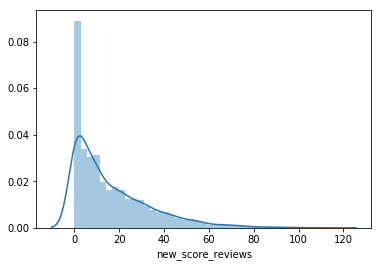

In [1745]:
'''
A histogram divides the variable into bins, counts the data points in each bin, 
and shows the bins on the x-axis and the counts on the y-axis.
'''
sns.distplot(y)

In [1746]:
# Correlation
'''
The correlation coefficient, or simply the correlation, is an index that ranges from -1 to 1. 
When the value is near zero, there is no linear relationship. 
As the correlation gets closer to plus or minus one, the relationship is stronger. 
A value of one (or negative one) indicates a perfect linear relationship between two variables.
'''

# result: 
# stronger correlation: host_is_superhost, instant_bookable, host_response_time, bedrooms, price, cleaning fee
# weaker corr: accommodates, beds, bathrooms, host_identity_verified, 
# almost no corr: zipcode, weekly_price, monthly_price, security_deposit, extra_people, cancellation_policy, minimum_nights

# seattle_data.corr()

'\nThe correlation coefficient, or simply the correlation, is an index that ranges from -1 to 1. \nWhen the value is near zero, there is no linear relationship. \nAs the correlation gets closer to plus or minus one, the relationship is stronger. \nA value of one (or negative one) indicates a perfect linear relationship between two variables.\n'

In [1747]:
# Split training and testing set. Training = 80%. Testing = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3044, 17) (3044,)
(761, 17) (761,)


In [1748]:
# Baseline model
# Make prediction by mean and median
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

from sklearn.dummy import DummyRegressor
# from sklearn.metrics import r2_score

# Create a dummy regressor
baseline_model = DummyRegressor(strategy='median')

# "Train" dummy regressor
baseline_model.fit(X_train, y_train)
# print(dummy_mean)

# Predict
# print("Baseline model predicitions using testing set ")
# print(X2.head())
# print("The predictions are:")
y_pred_bm = baseline_model.predict(X_test)
# print(y_pred_bm)
# print("The score is:")
# print(baseline_model.score(X_test, y_test))

print("rfr_model r2_score:", r2_score(y_test, y_pred_bm))
print("rfr_model ev_score:", explained_variance_score(y_test, y_pred_bm))
print("rfr_model mae:", mean_absolute_error(y_pred_bm, y_test))
print("rfr_model mse:", mean_squared_error(y_pred_bm, y_test))
print("rfr_model med_ae:", median_absolute_error(y_pred_bm, y_test))

rfr_model r2_score: -0.12033989470919826
rfr_model ev_score: 0.0
rfr_model mae: 13.024114323258868
rfr_model mse: 353.1815562089356
rfr_model med_ae: 9.942


Text(0, 0.5, 'Predictions (y_pred_lm)')

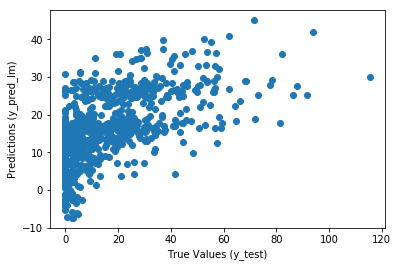

In [1749]:
# Linear Regression, stretch model?
lin_model = linear_model.LinearRegression()
lin_model = lin_model.fit(X_train, y_train)
y_pred_lm = lin_model.predict(X_test)
# print(y_pred_lm)

plt.scatter(y_test, y_pred_lm)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_lm)")

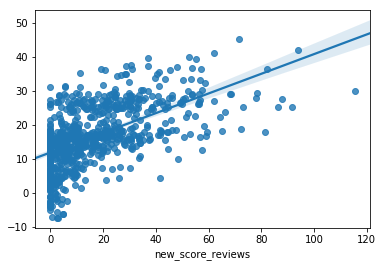

In [1750]:
sns.regplot(x=y_test, y=y_pred_lm);

In [1751]:
# print("lin_model score:", lin_model.score(X_test, y_test))
print("lin_model r2_score:", r2_score(y_test, y_pred_lm))
print("lin_model ev_score:", explained_variance_score(y_test, y_pred_lm))
print("lin_model mae:", mean_absolute_error(y_pred_lm, y_test))
print("lin_model mse:", mean_squared_error(y_pred_lm, y_test))
print("lin_model med_ae:", median_absolute_error(y_pred_lm, y_test))

lin_model r2_score: 0.3223501586770844
lin_model ev_score: 0.32237304303369385
lin_model mae: 10.661385130886293
lin_model mse: 213.62572791830138
lin_model med_ae: 8.212338411363135


In [1752]:
# The coefficients
print('Coefficients: \n', lin_model.coef_)
# The mean squared error (mse)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_lm))
# Explained variance score: 1 is perfect prediction, same as score
print('Variance score (same as score): %.3f' % r2_score(y_test, y_pred_lm))

Coefficients: 
 [-1.60501238e-02  9.59663259e-01  7.59530190e-02 -1.99980604e+00
 -1.03277111e-01 -1.20640722e-02  6.09900969e-04  2.14805937e-04
 -2.10722857e-03 -7.07223764e-02  4.66326070e-02 -1.61309119e-02
 -1.16148260e-01  1.04866759e+01  2.36693767e+00  9.50549861e+00
 -7.49124008e-01]
Mean squared error: 213.63
Variance score (same as score): 0.322


ridgecv_model r2_score: 0.322341781688378
ridgecv_model ev_score: 0.3223646638919003
ridgecv_model mae: 10.661456777610573
ridgecv_model mse: 213.62836872215175
ridgecv_model med_ae: 8.212366993890782


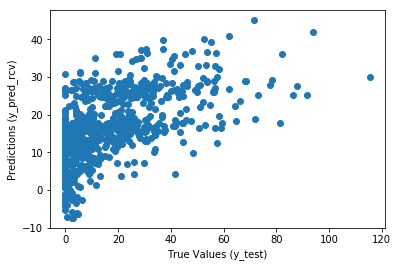

In [1753]:
# Ridge Regression with built-in cross-validation of the alpha parameter.
ridgecv_model = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=6, fit_intercept=True, scoring=None,
    normalize=False)
ridgecv_model.fit(X_train, y_train)
# ridgecv_model.alpha_
y_pred_rcv = ridgecv_model.predict(X_test)
# print(y_pred_rcv)

plt.scatter(y_test, y_pred_rcv)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_rcv)")

# print("ridgecv_model score:", ridgecv_model.score(X_test, y_test))
print("ridgecv_model r2_score:", r2_score(y_test, y_pred_rcv))
print("ridgecv_model ev_score:", explained_variance_score(y_test, y_pred_rcv))
print("ridgecv_model mae:", mean_absolute_error(y_pred_rcv, y_test))
print("ridgecv_model mse:", mean_squared_error(y_pred_rcv, y_test))
print("ridgecv_model med_ae:", median_absolute_error(y_pred_rcv, y_test))

Text(0, 0.5, 'Predictions (y_pred_ridge)')

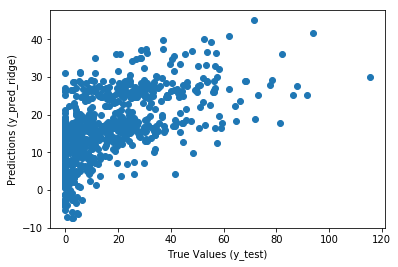

In [1754]:
# Ridge Regression
ridge_model = linear_model.Ridge(alpha=.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
ridge_model.fit(X_train, y_train)
# reg.coef_
# reg.intercept_
y_pred_ridge = ridge_model.predict(X_test)
# print(y_pred_ridge)

plt.scatter(y_test, y_pred_ridge)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_ridge)")

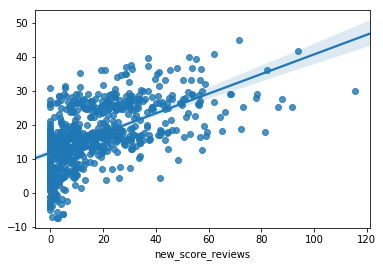

In [1755]:
sns.regplot(x=y_test, y=y_pred_ridge);

In [1756]:
# print("ridge_model score:", ridge_model.score(X_test, y_test))
print("ridge_model r2_score:", r2_score(y_test, y_pred_ridge))
print("ridge_model ev_score:", explained_variance_score(y_test, y_pred_ridge))
print("ridge_model mae:", mean_absolute_error(y_pred_ridge, y_test))
print("ridge_model mse:", mean_squared_error(y_pred_ridge, y_test))
print("ridge_model med_ae:", median_absolute_error(y_pred_ridge, y_test))

ridge_model r2_score: 0.32230821067246496
ridge_model ev_score: 0.3223310842820073
ridge_model mae: 10.661743095356572
ridge_model mse: 213.6389518172461
ridge_model med_ae: 8.213574741531483


Cross-validated scores: [ 0.21546241  0.28762751  0.28189387  0.24390108  0.25506256  0.26884101
 -2.61113245  0.27962862  0.39240827]
cross_val_predict r2_score: 0.31533932712533697
cross_val_predict ev_score: 0.31533969540912477
cross_val_predict mae: 10.804557159850287
cross_val_predict mse: 215.83585754901276
cross_val_predict med_ae: 8.195838934614567


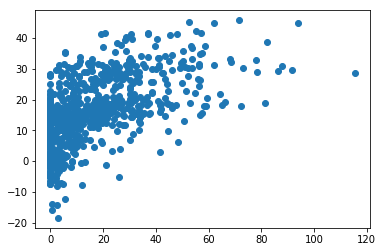

In [1757]:
# Perform 9-fold cross validation (cv)

scores = cross_val_score(lin_model, X, y, cv=9)
print("Cross-validated scores:", scores)                                         

# As you can see, the last fold improved the score of the original model — from 0.322 to 0.392

# Make cross validated predictions
y_pred_cvp = cross_val_predict(lin_model, X_test, y_test, cv=9)
# print(y_pred_cvp)
plt.scatter(y_test, y_pred_cvp)

# Cross-Predicted Accuracy, r2_score
# accuracy = metrics.r2_score(y_test, y_pred_cvp)
# print("Cross-Predicted Accuracy:", accuracy)

# print("cross_val_predict mae:", mean_absolute_error(y_pred_cvp, y_test))
print("cross_val_predict r2_score:", r2_score(y_test, y_pred_cvp))
print("cross_val_predict ev_score:", explained_variance_score(y_test, y_pred_cvp))
print("cross_val_predict mae:", mean_absolute_error(y_pred_cvp, y_test))
print("cross_val_predict mse:", mean_squared_error(y_pred_cvp, y_test))
print("cross_val_predict med_ae:", median_absolute_error(y_pred_cvp, y_test))

Text(0, 0.5, 'Predictions (y_pred_lasso)')

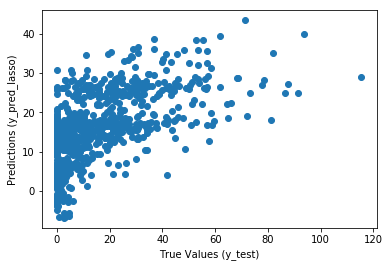

In [1758]:
# Lasso Regression
lasso_model = linear_model.Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

plt.scatter(y_test, y_pred_lasso)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_lasso)")

In [1759]:
# print("lasso_model score:", lasso_model.score(X_test, y_test))

print("lasso_model r2_score:", r2_score(y_test, y_pred_lasso))
print("lasso_model ev_score:", explained_variance_score(y_test, y_pred_lasso))
print("lasso_model mae:", mean_absolute_error(y_pred_lasso, y_test))
print("lasso_model mse:", mean_squared_error(y_pred_lasso, y_test))
print("lasso_model med_ae:", median_absolute_error(y_pred_lasso, y_test))

lasso_model r2_score: 0.31782773995165603
lasso_model ev_score: 0.31784930403331724
lasso_model mae: 10.6980250128968
lasso_model mse: 215.05139783402802
lasso_model med_ae: 8.251199124458164


Text(0, 0.5, 'Predictions (y_pred_dtr)')

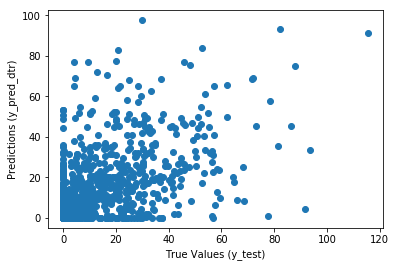

In [1760]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

dtr_model = DecisionTreeRegressor()
dtr_model = dtr_model.fit(X_train, y_train)
y_pred_dtr = dtr_model.predict(X_test)

plt.scatter(y_test, y_pred_dtr)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_dtr)")


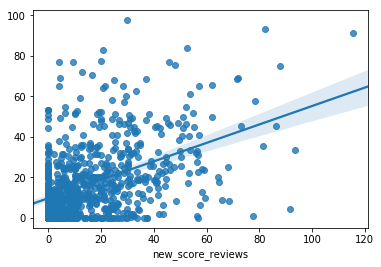

In [1761]:
sns.regplot(x=y_test, y=y_pred_dtr);

In [1762]:
# print("dtr_model score:", dtr_model.score(X_test, y_test))

print("dtr_model r2_score:", r2_score(y_test, y_pred_dtr))
print("dtr_model ev_score:", explained_variance_score(y_test, y_pred_dtr))
print("dtr_model mae:", mean_absolute_error(y_pred_dtr, y_test))
print("dtr_model mse:", mean_squared_error(y_pred_dtr, y_test))
print("dtr_model med_ae:", median_absolute_error(y_pred_dtr, y_test))

dtr_model r2_score: -0.1112535066948721
dtr_model ev_score: -0.10942804152819319
dtr_model mae: 12.91856767411301
dtr_model mse: 350.31711776987515
dtr_model med_ae: 8.6


[0.09530789 0.03210362 0.02251223 0.02483156 0.01582465 0.12527684
 0.0590654  0.05294428 0.03838474 0.10170245 0.05346347 0.07522294
 0.14587976 0.06682052 0.0158356  0.03819375 0.0366303 ]


Text(0, 0.5, 'Predictions (y_pred_rfr)')

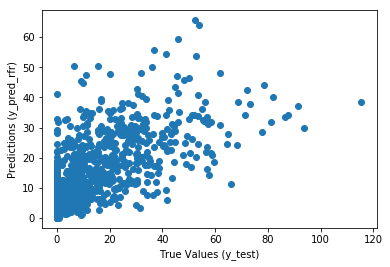

In [1763]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# X, y = make_regression(n_features=17, n_informative=2, random_state=0, shuffle=False)
# rfr_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
#            max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
#            oob_score=False, random_state=0, verbose=0, warm_start=False)

rfr_model = RandomForestRegressor(random_state=1)
rfr_model.fit(X_train, y_train)
y_pred_rfr = rfr_model.predict(X_test)

print(rfr_model.feature_importances_)
# print(y_pred_rfr)

plt.scatter(y_test, y_pred_rfr)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_rfr)")

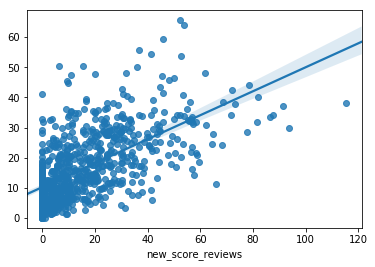

In [1764]:
sns.regplot(x=y_test, y=y_pred_rfr);

In [1765]:
# score = r2_score: 0-1, 1 is the best
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
# mean_ae: MAE output is non-negative floating point. The best value is 0.0
# mse: A non-negative floating point value (the best value is 0.0)
# msle: A non-negative floating point value (the best value is 0.0)
# median_ae: A positive floating point value (the best value is 0.0)

# print("rfr_model score:", rfr_model.score(X_test, y_test))
print("rfr_model r2_score:", r2_score(y_test, y_pred_rfr))
print("rfr_model ev_score:", explained_variance_score(y_test, y_pred_rfr))
print("rfr_model mae:", mean_absolute_error(y_pred_rfr, y_test))
print("rfr_model mse:", mean_squared_error(y_pred_rfr, y_test))
# print("rfr_model msle:", mean_squared_log_error(y_pred_rfr, y_test))
print("rfr_model med_ae:", median_absolute_error(y_pred_rfr, y_test))


rfr_model r2_score: 0.3677538939581594
rfr_model ev_score: 0.3679691862110922
rfr_model mae: 9.986079432324608
rfr_model mse: 199.31242714235162
rfr_model med_ae: 7.208100000000002


In [1766]:
# What attributes affect earning? Assume new_score_reviews proportional to earning.
'''
The boundaries of top performer listings: 44.109
The boundaries of low performer listings: 6.480000000000001
Extract rows that is top performer -> list
Extract rows that is low performer -> list
Compare attributes, analyze the correlation? Then decide which attributes has causal effect to new_score_reviews.

'''



'\nThe boundaries of top performer listings: 44.109\nThe boundaries of low performer listings: 6.480000000000001\nExtract rows that is top performer -> list\nExtract rows that is low performer -> list\nCompare attributes, analyze the correlation? Then decide which attributes has causal effect to new_score_reviews.\n\n'